In [ ]:
import os, glob, time, random, cv2

# Data and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from tqdm import tqdm

# Audio processing
import librosa
import librosa.display
from IPython.display import Audio

# ML/DL
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.models as models
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input

# Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, roc_curve, auc,
    precision_recall_fscore_support, confusion_matrix, matthews_corrcoef)

In [ ]:
data_path = "/kaggle/input/urbansound8k"
data_csv = "/kaggle/input/urbansound8k/UrbanSound8K.csv"

data = pd.read_csv(data_csv)
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


<Axes: title={'center': 'Audio Class Distribution'}, xlabel='class'>

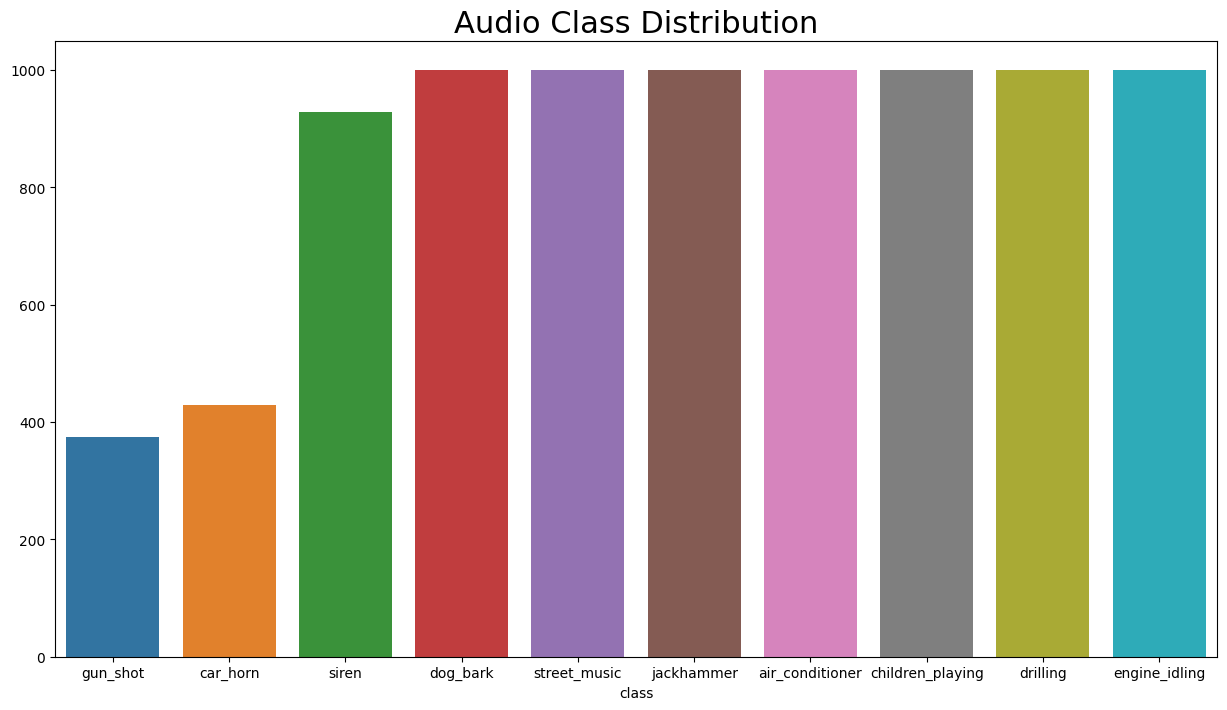

In [ ]:
# View Dataset Labels Distribution
plt.figure(figsize=(15, 8))
plt.title('Audio Class Distribution', fontsize=22)
class_distribution = data['class'].value_counts().sort_values()
class_names = pd.Series(class_distribution.index)
sample_counts = class_distribution.values
sns.barplot(x=class_names, y=sample_counts)

In [ ]:
# Number of folders
print("Folds:", sorted(data['fold'].unique()))

Folds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


<Axes: title={'center': 'Audio Folds Distribution'}, xlabel='fold'>

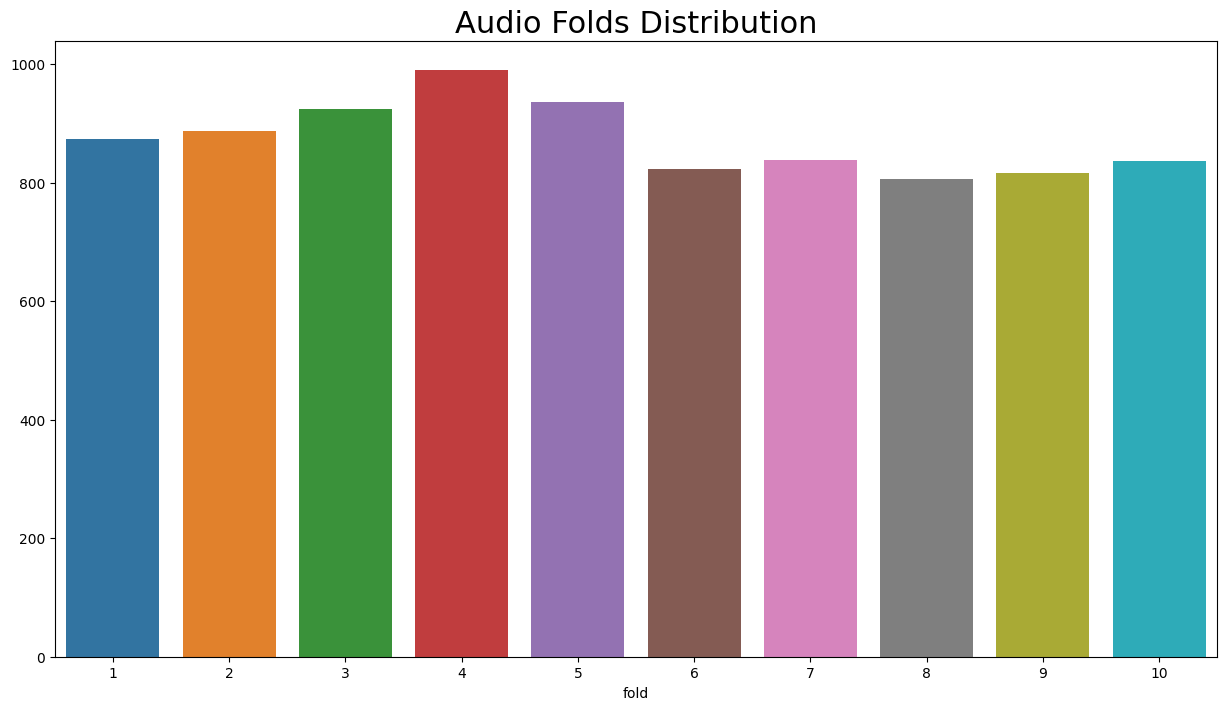

In [ ]:
# Folds Distribution
plt.figure(figsize=(15, 8))
plt.title('Audio Folds Distribution', fontsize=22)
folds_distribution = data['fold'].value_counts().sort_index()

fold_ids = pd.Series(folds_distribution.index)
sample_counts = folds_distribution.values
sns.barplot(x=fold_ids, y=sample_counts)

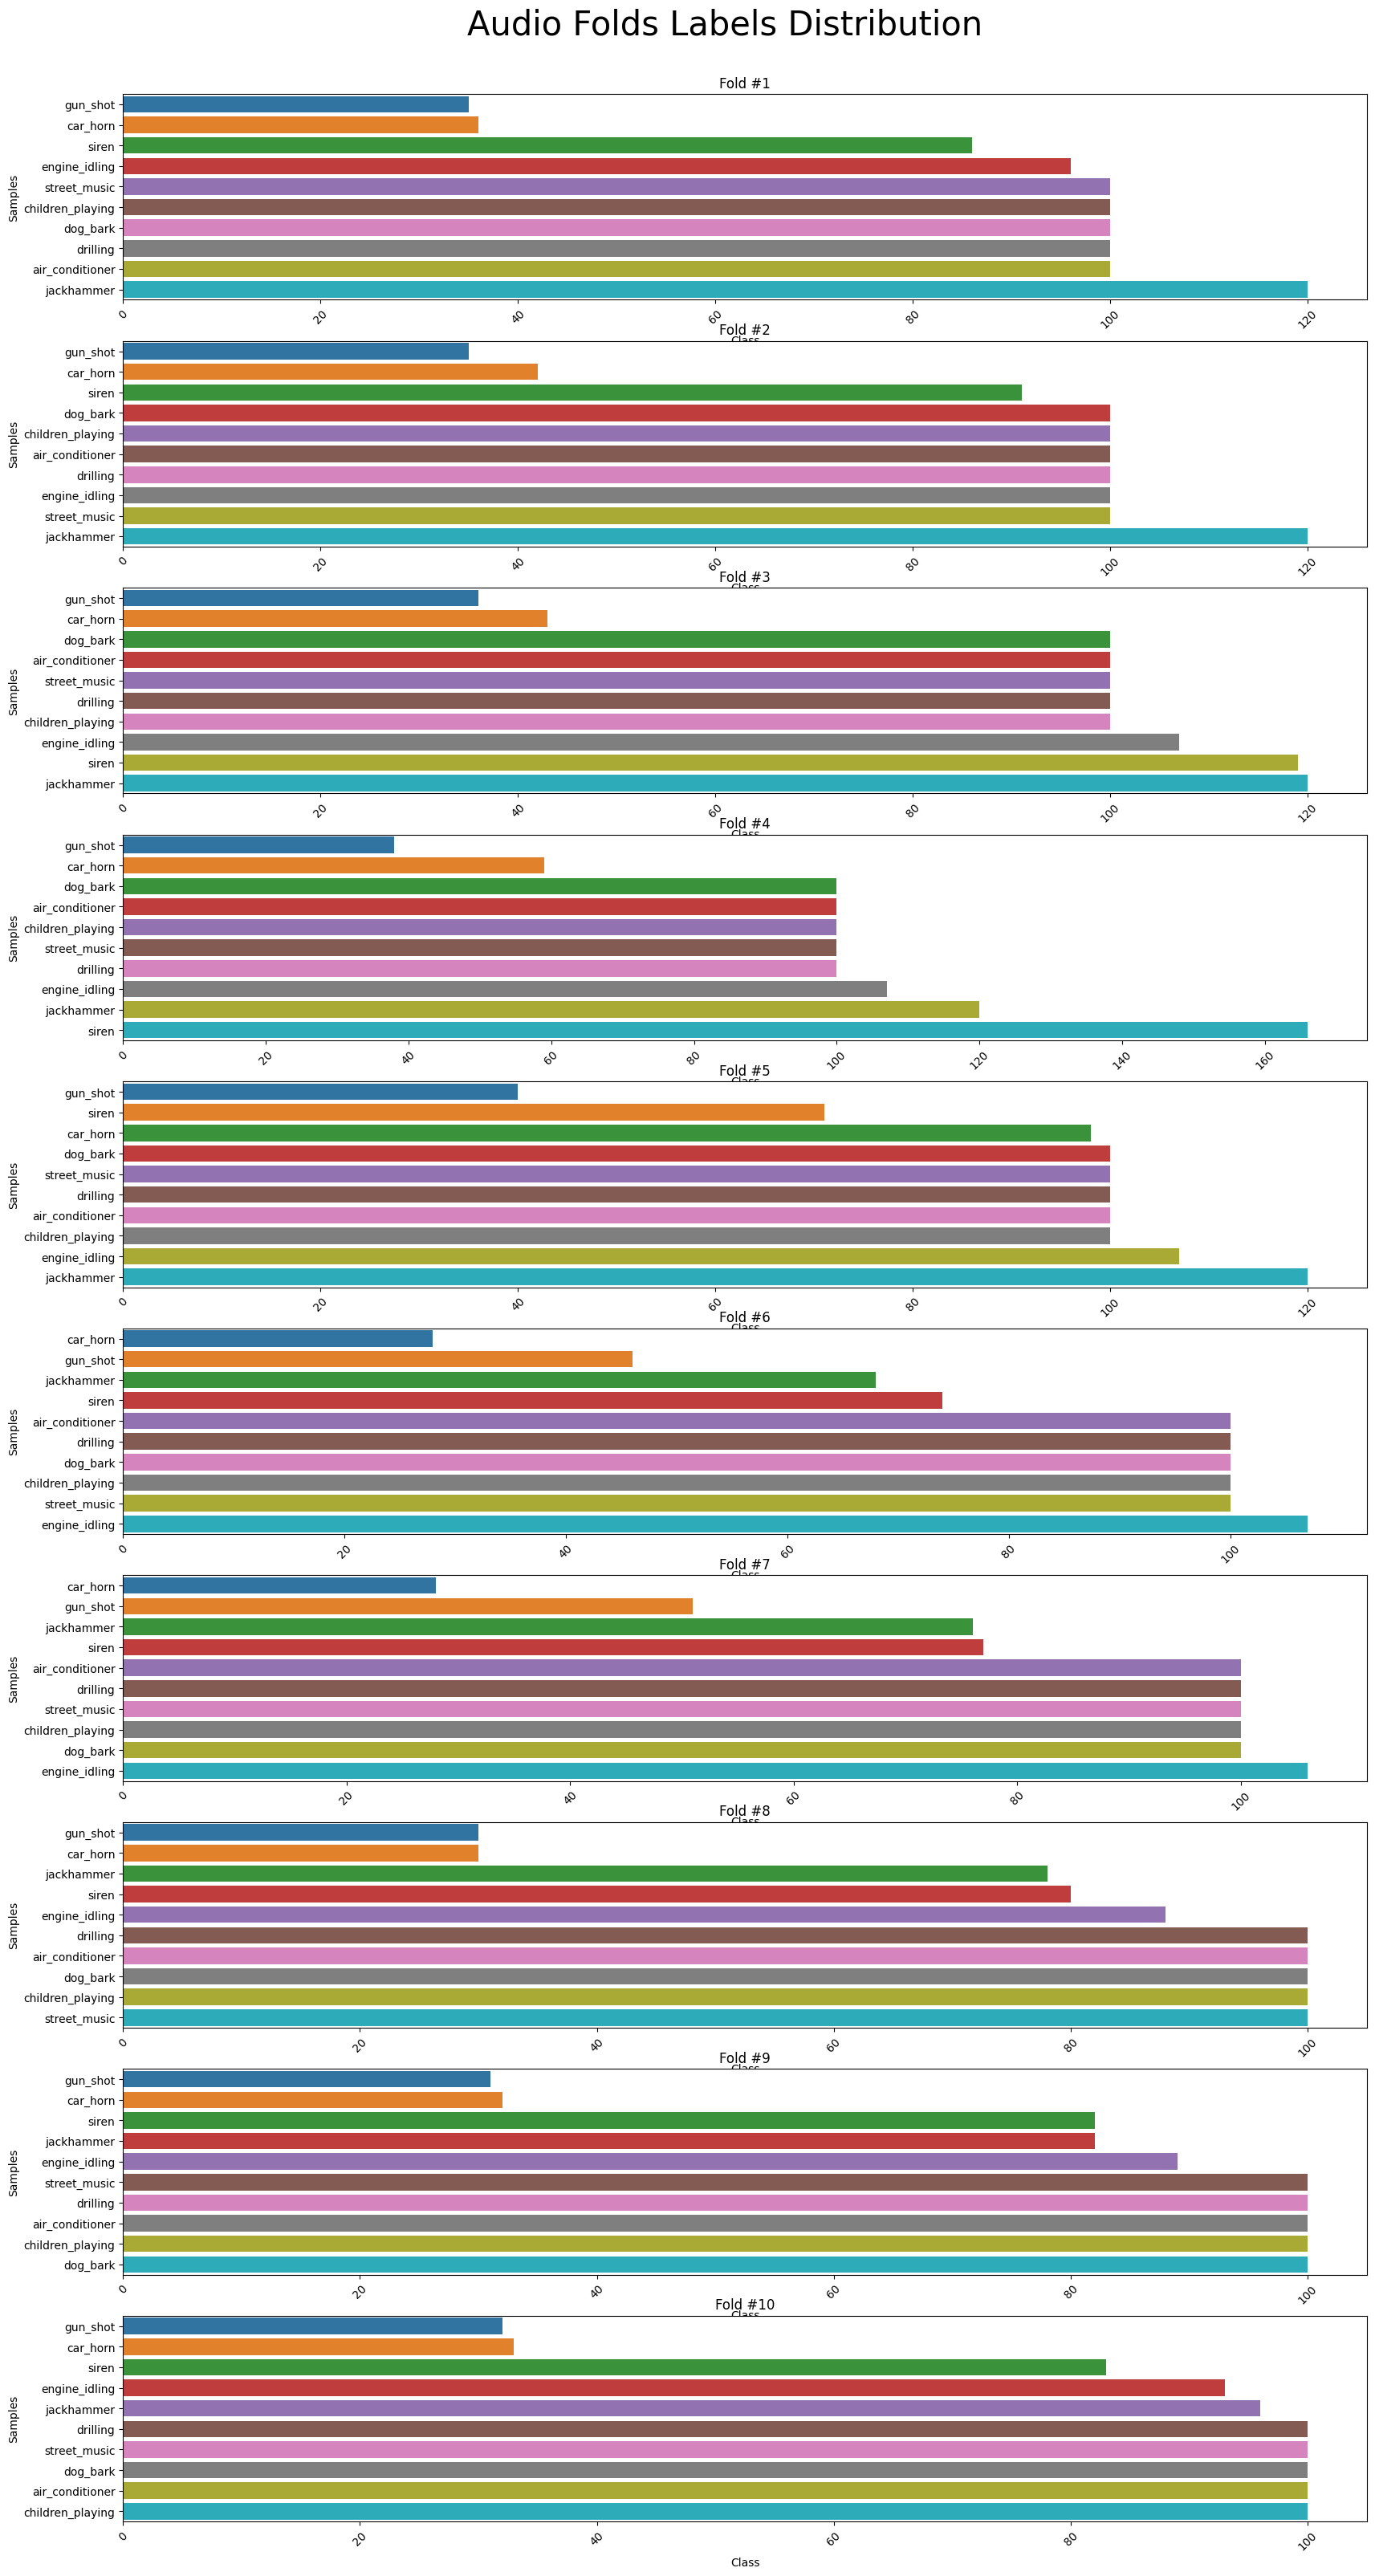

In [ ]:
# Full Dataset Folds Distribution
fig = plt.figure(figsize=(20, 36))
fig.suptitle('Audio Folds Labels Distribution', fontsize=30)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

folds = sorted(data['fold'].unique())
fold_groups = data.groupby(by='fold')

for i, fold in enumerate(folds, start=1):
    query = fold_groups.get_group(fold)
    class_distribution = query['class'].value_counts().sort_values()
    plt.subplot(len(folds), 1, i)
    plt.title(f'Fold #{fold}')
    class_names = pd.Series(class_distribution.index)
    sample_counts = class_distribution.values
    sns.barplot(x=sample_counts, y=class_names)

    plt.xticks(rotation=45)
    plt.xlabel("Class")
    plt.ylabel("Samples")

In [ ]:
def view_sample(df, idx):
    print('==============================================')
    print(f"Filename:\t{df['slice_file_name'][idx]}")
    print(f"Fold:\t\t{df['fold'][idx]}")
    print(f"Class:\t\t{df['class'][idx]}\n\n")
    sample_path = data_path + f"/fold{df['fold'][idx]}/{df['slice_file_name'][idx]}"
    display.display(display.Audio(filename=sample_path))
    print('==============================================')
    return

def generate_spectrogram(waveform, length=255, step=128, fft_length=255):
    # Computing Short-Time Fourier Transform of waveform
    spectrogram = tf.signal.stft(waveform,
                                frame_length=length,
                                frame_step=step,
                                fft_length=fft_length)
    # Getting magnitude of STFT
    spectrogram = tf.abs(spectrogram)
    # Converting spectrogram into image with (height, width, channels) dimensions
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_audio_data(waveform, figsize=(16, 8)):
    fig, (ax1, ax2) = plt.subplots(2, figsize=figsize)
    # Waveform Plot
    ax1.plot(waveform)
    ax1.set_title('Waveform')
    ax1.set_xlim([0, len(waveform)])

    # Spectrogram Plot
    spectrogram = generate_spectrogram(waveform)
    # Viewing shapes
    print(f'Waveform shape: {waveform.shape}')
    print(f'Spectrogram shape: {spectrogram.shape}')
    # Converting spectrogram shape to 3D if 2D
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    # Spectrogram Plot
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax2.pcolormesh(X, Y, log_spec)
    ax2.set_title('Spectrogram')
    plt.show()
    return

In [ ]:
idx = random.sample(data.index.to_list(), 1)[0]
view_sample(data, idx)

Filename:	142003-2-0-1.wav
Fold:		8
Class:		children_playing




Waveform shape: (88200,)
Spectrogram shape: (688, 128, 1)


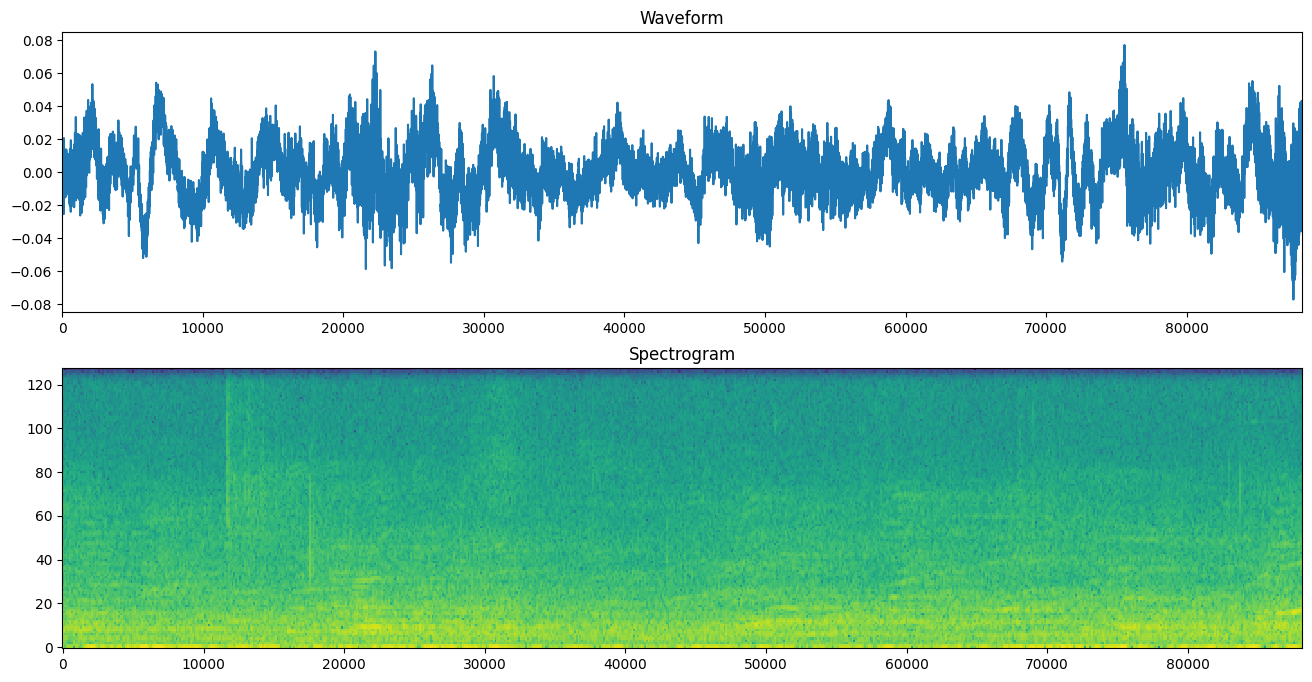

In [ ]:
sample_path = data_path + f"/fold{data['fold'][idx]}/{data['slice_file_name'][idx]}"
# Loading the selected audio data
waveform, sample_rate = librosa.load(sample_path)
#Spectrograms let CNNs detect temporal patterns and frequency-specific features (like noise, and tone).
plot_audio_data(tf.squeeze(waveform))

In [ ]:
X = []
y = []
up_width = 173
up_height = 40
for _, dat in tqdm(data.iterrows(), total=len(data), desc="Processing Audio Files"):
    file_name = os.path.join(os.path.abspath(data_path), 'fold' + str(dat['fold']) + '/', str(dat['slice_file_name']))
    # Loading audio file
    raw, sr = librosa.load(file_name, sr=None)
    # Extracting MFCC features
    X_ = librosa.feature.mfcc(y=raw, sr=sr, n_mfcc=40)
    # Resizing the feature matrix to (up_width, up_height)
    X_ = cv2.resize(X_, (up_width, up_height), interpolation=cv2.INTER_LINEAR)
    # Appending the feature and label
    X.append(X_)
    y.append(dat['classID'])
# Converting lists to numpy arrays
X = np.array(X)
y = np.array(y)
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Processing Audio Files:  33%|███▎      | 2844/8732 [00:49<01:43, 56.68it/s]/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Processing Audio Files: 100%|██████████| 8732/8732 [02:31<00:00, 57.50it/s]

Features shape: (8732, 40, 173)
Labels shape: (8732,)


In [ ]:
# one-hot encoding
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
# train-test split
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)
INPUTSHAPE = (up_height,up_width,1)
INPUTSHAPE

(40, 173, 1)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6985, 40, 173, 1)
y_train shape: (6985, 10)
X_test shape: (1747, 40, 173, 1)
y_test shape: (1747, 10)


In [ ]:
# CNN
model =  models.Sequential([

                          layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          layers.MaxPooling2D(2, padding='same'),
                          layers.Dropout(0.3),
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(256 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 171, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 84, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 42, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 42, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 40, 128)          │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 20, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,490 (861.29 KB)

 Trainable params: 220,490 (861.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train ,
            validation_data=(X_test,y_test),
            epochs=15,
            callbacks = [callback],batch_size=8)

Epoch 1/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3883 - loss: 1.7688 - val_accuracy: 0.6022 - val_loss: 1.1665
Epoch 2/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6424 - loss: 1.0522 - val_accuracy: 0.7676 - val_loss: 0.7613
Epoch 3/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7761 - loss: 0.6949 - val_accuracy: 0.8420 - val_loss: 0.5399
Epoch 4/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8302 - loss: 0.5003 - val_accuracy: 0.8643 - val_loss: 0.4648
Epoch 5/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8578 - loss: 0.4123 - val_accuracy: 0.8603 - val_loss: 0.4307
Epoch 6/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8771 - loss: 0.3588 - val_accuracy: 0.8798 - val_loss: 0.3904
Epoch 7/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8948 - loss: 0.3028 - val_accuracy: 0.8735 - val_loss: 0.3889
Epoch 8/15
874/874 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9096 - loss: 0.2724 - val_accuracy: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9057 - loss: 0.3993
Test Accuracy: 89.01%


In [ ]:
Y_pred = model.predict(X_test)
Y_pred = [np.argmax(i) for i in Y_pred]
y_test = [np.argmax(i) for i in y_test]
print(classification_report(y_test,Y_pred))

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       203
           1       0.93      0.88      0.90        86
           2       0.81      0.89      0.84       183
           3       0.83      0.89      0.86       201
           4       0.91      0.87      0.89       206
           5       0.93      0.93      0.93       193
           6       0.73      1.00      0.85        72
           7       0.98      0.90      0.94       208
           8       0.85      0.98      0.91       165
           9       0.93      0.70      0.80       230

    accuracy                           0.89      1747
   macro avg       0.89      0.90      0.89      1747
weighted avg       0.90      0.89      0.89      1747



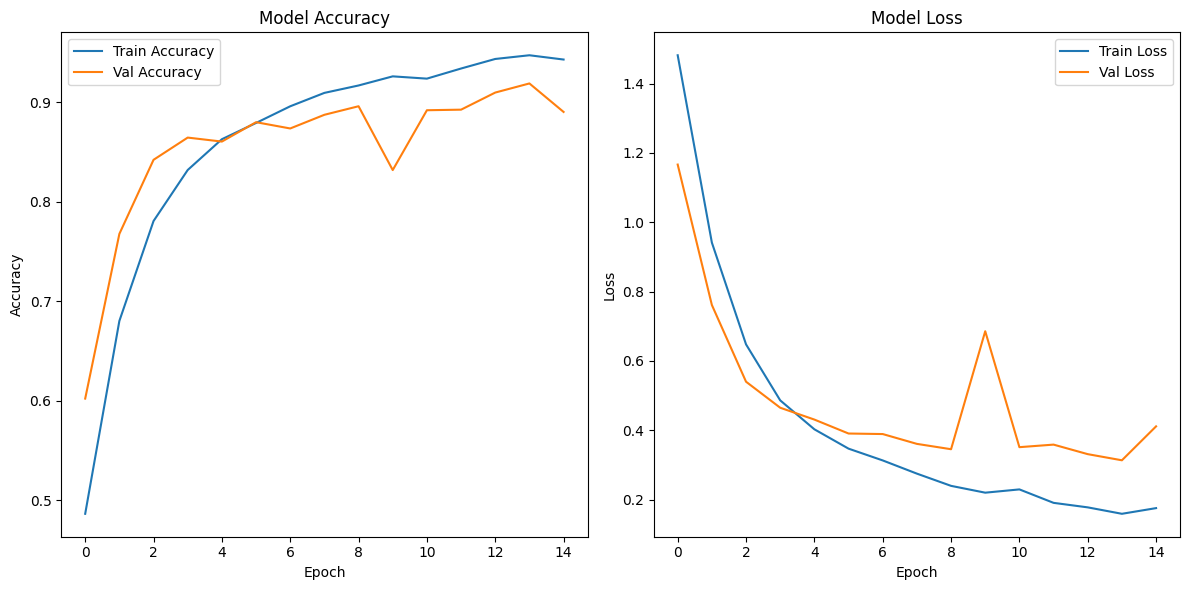

In [ ]:
# accuracy Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Investigating another feature extraction technique
# Log-Mel Spectrogram
X_log_mel = []
y_log_mel = []
up_width = 173
up_height = 40

# Log-Mel Spectrogram Feature Extraction
for _, dat in tqdm(data.iterrows(), total=len(data), desc="Processing Log-Mel Spectrogram"):
    file_name = os.path.join(os.path.abspath(data_path), 'fold' + str(dat['fold']) + '/', str(dat['slice_file_name']))
    # Loading audio
    raw, sr = librosa.load(file_name, sr=None)
    # Extracting Log-Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=raw, sr=sr, n_mels=40)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    # Resizing the spectrogram to match input shape
    log_mel_spectrogram = cv2.resize(log_mel_spectrogram, (up_width, up_height), interpolation=cv2.INTER_LINEAR)
    # Appending feature and label
    X_log_mel.append(log_mel_spectrogram)
    y_log_mel.append(dat['classID'])

# Converting to numpy arrays
X_log_mel = np.array(X_log_mel)
y_log_mel = np.array(y_log_mel)

# Defining num_classes based on the unique values in the label data
num_classes = len(np.unique(y_log_mel))

# One-hot encoding for y_log_mel (for 10 classes)
y_log_mel = to_categorical(y_log_mel, num_classes)

# Reshaping X for CNN input
X_log_mel = X_log_mel.reshape(X_log_mel.shape[0], X_log_mel.shape[1], X_log_mel.shape[2], 1)

print(f"Log-Mel Spectrogram Features Shape: {X_log_mel.shape}")

# Train-test split for Log-Mel Spectrogram features
X_train_log_mel, X_test_log_mel, y_train_log_mel, y_test_log_mel = train_test_split(
    X_log_mel, y_log_mel, test_size=0.2, random_state=42, stratify=y_log_mel)

# Further split the training data to get a validation set
X_train_log_mel, X_val_log_mel, y_train_log_mel, y_val_log_mel = train_test_split(
    X_train_log_mel, y_train_log_mel, test_size=0.1, random_state=42, stratify=y_train_log_mel)

# Checing the shapes
print(f"X_train_log_mel shape: {X_train_log_mel.shape}")
print(f"X_val_log_mel shape: {X_val_log_mel.shape}")
print(f"X_test_log_mel shape: {X_test_log_mel.shape}")
print(f"y_train_log_mel shape: {y_train_log_mel.shape}")
print(f"y_val_log_mel shape: {y_val_log_mel.shape}")
print(f"y_test_log_mel shape: {y_test_log_mel.shape}")

Processing Log-Mel Spectrogram: 100%|██████████| 8732/8732 [02:12<00:00, 66.06it/s] 


Log-Mel Spectrogram Features Shape: (8732, 40, 173, 1)
X_train_log_mel shape: (6286, 40, 173, 1)
X_val_log_mel shape: (699, 40, 173, 1)
X_test_log_mel shape: (1747, 40, 173, 1)
y_train_log_mel shape: (6286, 10)
y_val_log_mel shape: (699, 10)
y_test_log_mel shape: (1747, 10)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

# CNN Model Training
history = model.fit(X_train_log_mel, y_train_log_mel,
                    validation_data=(X_val_log_mel, y_val_log_mel),
                    epochs=15,
                    callbacks=[callback],
                    batch_size=32)

# Evaluating the Model on Test Set
test_loss, test_accuracy = model.evaluate(X_test_log_mel, y_test_log_mel)
print(f"Log-Mel Spectrogram Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5522 - loss: 1.2761 - val_accuracy: 0.6266 - val_loss: 1.1139
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6696 - loss: 0.9808 - val_accuracy: 0.7382 - val_loss: 0.8209
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7269 - loss: 0.8140 - val_accuracy: 0.7740 - val_loss: 0.7455
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7709 - loss: 0.6925 - val_accuracy: 0.7568 - val_loss: 0.6598
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8077 - loss: 0.5836 - val_accuracy: 0.7697 - val_loss: 0.7192
Epoch 6/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8115 - loss: 0.5510 - val_accuracy: 0.8083 - val_loss: 0.5369
Epoch 7/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8456 - loss: 0.4583 - val_accuracy: 0.8512 - val_loss: 0.4401
Epoch 8/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8593 - loss: 0.4082 - val_accuracy: 0

In [ ]:
# Chroma Feature Extraction
X_chroma = []
y_chroma = []
up_width = 173
up_height = 40

for _, dat in tqdm(data.iterrows(), total=len(data), desc="Processing Chroma Features"):
    file_name = os.path.join(os.path.abspath(data_path), 'fold' + str(dat['fold']) + '/', str(dat['slice_file_name']))

    # Loading audio
    raw, sr = librosa.load(file_name, sr=None)

    # Extracting Chroma Features
    chroma = librosa.feature.chroma_stft(y=raw, sr=sr, n_chroma=12)

    # Resizing the chroma features to match the input shape
    chroma_resized = cv2.resize(chroma, (up_width, up_height), interpolation=cv2.INTER_LINEAR)

    # Appending feature and label
    X_chroma.append(chroma_resized)
    y_chroma.append(dat['classID'])

# Converting to numpy arrays
X_chroma = np.array(X_chroma)
y_chroma = np.array(y_chroma)

# Defining num_classes based on the unique values in the label data
num_classes = len(np.unique(y_chroma))

# One-hot encoding for y_chroma (for 10 classes)
y_chroma = to_categorical(y_chroma, num_classes)

# Reshaping X for CNN input
X_chroma = X_chroma.reshape(X_chroma.shape[0], X_chroma.shape[1], X_chroma.shape[2], 1)

print(f"Chroma Features Shape: {X_chroma.shape}")

# Train-test split for Chroma features
X_train_chroma, X_test_chroma, y_train_chroma, y_test_chroma = train_test_split(
    X_chroma, y_chroma, test_size=0.2, random_state=42, stratify=y_chroma)

# Further split the training data to get a validation set
X_train_chroma, X_val_chroma, y_train_chroma, y_val_chroma = train_test_split(
    X_train_chroma, y_train_chroma, test_size=0.1, random_state=42, stratify=y_train_chroma)

# Checking the shapes
print(f"X_train_chroma shape: {X_train_chroma.shape}")
print(f"X_val_chroma shape: {X_val_chroma.shape}")
print(f"X_test_chroma shape: {X_test_chroma.shape}")
print(f"y_train_chroma shape: {y_train_chroma.shape}")
print(f"y_val_chroma shape: {y_val_chroma.shape}")
print(f"y_test_chroma shape: {y_test_chroma.shape}")

Processing Chroma Features:   1%|▏         | 119/8732 [00:02<03:26, 41.67it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing Chroma Features: 100%|██████████| 8732/8732 [03:37<00:00, 40.23it/s]


Chroma Features Shape: (8732, 40, 173, 1)
X_train_chroma shape: (6286, 40, 173, 1)
X_val_chroma shape: (699, 40, 173, 1)
X_test_chroma shape: (1747, 40, 173, 1)
y_train_chroma shape: (6286, 10)
y_val_chroma shape: (699, 10)
y_test_chroma shape: (1747, 10)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

# CNN Model Training
history = model.fit(X_train_chroma, y_train_chroma,
                    validation_data=(X_val_chroma, y_val_chroma),
                    epochs=15,
                    callbacks=[callback],
                    batch_size=32)

# Evaluating the Model on Test Set
test_loss, test_accuracy = model.evaluate(X_test_chroma, y_test_chroma)
print(f"Chroma Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1639 - loss: 2.3449 - val_accuracy: 0.2647 - val_loss: 1.9023
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2961 - loss: 1.8249 - val_accuracy: 0.4049 - val_loss: 1.6848
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3620 - loss: 1.6647 - val_accuracy: 0.4134 - val_loss: 1.6229
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4241 - loss: 1.5622 - val_accuracy: 0.4707 - val_loss: 1.4690
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4671 - loss: 1.4576 - val_accuracy: 0.4950 - val_loss: 1.3923
Epoch 6/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5046 - loss: 1.3736 - val_accuracy: 0.5250 - val_loss: 1.3464
Epoch 7/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5317 - loss: 1.3115 - val_accuracy: 0.5494 - val_loss: 1.2872
Epoch 8/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5499 - loss: 1.2640 - val_accuracy: 0.

In [ ]:
# Spectral Centroid Feature Extraction
X_spectral_centroid = []
y_spectral_centroid = []
up_width = 173
up_height = 40

for _, dat in tqdm(data.iterrows(), total=len(data), desc="Processing Spectral Centroid"):
    file_name = os.path.join(os.path.abspath(data_path), 'fold' + str(dat['fold']) + '/', str(dat['slice_file_name']))

    # Loading audio
    raw, sr = librosa.load(file_name, sr=None)

    # Extracting Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=raw, sr=sr)

    # Resizing the spectral centroid to match input shape
    spectral_centroid_resized = cv2.resize(spectral_centroid, (up_width, up_height), interpolation=cv2.INTER_LINEAR)

    # Appending feature and label
    X_spectral_centroid.append(spectral_centroid_resized)
    y_spectral_centroid.append(dat['classID'])

# Converting to numpy arrays
X_spectral_centroid = np.array(X_spectral_centroid)
y_spectral_centroid = np.array(y_spectral_centroid)

# One-hot encoding
y_spectral_centroid = to_categorical(y_spectral_centroid, num_classes)

# Reshaping X for CNN input
X_spectral_centroid = X_spectral_centroid.reshape(X_spectral_centroid.shape[0], X_spectral_centroid.shape[1], X_spectral_centroid.shape[2], 1)

print(f"Spectral Centroid Features Shape: {X_spectral_centroid.shape}")

# Train-test split for Spectral Centroid features
X_train_spectral_centroid, X_test_spectral_centroid, y_train_spectral_centroid, y_test_spectral_centroid = train_test_split(
    X_spectral_centroid, y_spectral_centroid, test_size=0.2, random_state=42, stratify=y_spectral_centroid)

# Further split the training data to get a validation set
X_train_spectral_centroid, X_val_spectral_centroid, y_train_spectral_centroid, y_val_spectral_centroid = train_test_split(
    X_train_spectral_centroid, y_train_spectral_centroid, test_size=0.1, random_state=42, stratify=y_train_spectral_centroid)

# Checking the shapes
print(f"X_train_spectral_centroid shape: {X_train_spectral_centroid.shape}")
print(f"X_val_spectral_centroid shape: {X_val_spectral_centroid.shape}")
print(f"X_test_spectral_centroid shape: {X_test_spectral_centroid.shape}")
print(f"y_train_spectral_centroid shape: {y_train_spectral_centroid.shape}")
print(f"y_val_spectral_centroid shape: {y_val_spectral_centroid.shape}")
print(f"y_test_spectral_centroid shape: {y_test_spectral_centroid.shape}")


Processing Spectral Centroid: 100%|██████████| 8732/8732 [02:31<00:00, 57.79it/s] 


Spectral Centroid Features Shape: (8732, 40, 173, 1)
X_train_spectral_centroid shape: (6286, 40, 173, 1)
X_val_spectral_centroid shape: (699, 40, 173, 1)
X_test_spectral_centroid shape: (1747, 40, 173, 1)
y_train_spectral_centroid shape: (6286, 10)
y_val_spectral_centroid shape: (699, 10)
y_test_spectral_centroid shape: (1747, 10)


In [ ]:
# Zero-Crossing Rate Feature Extraction
X_zero_crossing = []
y_zero_crossing = []
up_width = 173
up_height = 40

for _, dat in tqdm(data.iterrows(), total=len(data), desc="Processing Zero-Crossing Rate"):
    file_name = os.path.join(os.path.abspath(data_path), 'fold' + str(dat['fold']) + '/', str(dat['slice_file_name']))

    # Loading audio
    raw, sr = librosa.load(file_name, sr=None)

    # Extracting Zero-Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=raw)

    # Resizing the zero-crossing rate to match input shape
    zero_crossing_resized = cv2.resize(zero_crossing_rate, (up_width, up_height), interpolation=cv2.INTER_LINEAR)

    # Appending feature and label
    X_zero_crossing.append(zero_crossing_resized)
    y_zero_crossing.append(dat['classID'])

# Converting to numpy arrays
X_zero_crossing = np.array(X_zero_crossing)
y_zero_crossing = np.array(y_zero_crossing)

# One-hot encoding
y_zero_crossing = to_categorical(y_zero_crossing, num_classes)

# Reshaping X for CNN input
X_zero_crossing = X_zero_crossing.reshape(X_zero_crossing.shape[0], X_zero_crossing.shape[1], X_zero_crossing.shape[2], 1)

print(f"Zero-Crossing Rate Features Shape: {X_zero_crossing.shape}")

# Train-test split for Zero-Crossing Rate features
X_train_zero_crossing, X_test_zero_crossing, y_train_zero_crossing, y_test_zero_crossing = train_test_split(
    X_zero_crossing, y_zero_crossing, test_size=0.2, random_state=42, stratify=y_zero_crossing)

# Further split the training data to get a validation set
X_train_zero_crossing, X_val_zero_crossing, y_train_zero_crossing, y_val_zero_crossing = train_test_split(
    X_train_zero_crossing, y_train_zero_crossing, test_size=0.1, random_state=42, stratify=y_train_zero_crossing)

# Checking the shapes
print(f"X_train_zero_crossing shape: {X_train_zero_crossing.shape}")
print(f"X_val_zero_crossing shape: {X_val_zero_crossing.shape}")
print(f"X_test_zero_crossing shape: {X_test_zero_crossing.shape}")
print(f"y_train_zero_crossing shape: {y_train_zero_crossing.shape}")
print(f"y_val_zero_crossing shape: {y_val_zero_crossing.shape}")
print(f"y_test_zero_crossing shape: {y_test_zero_crossing.shape}")

Processing Zero-Crossing Rate: 100%|██████████| 8732/8732 [01:32<00:00, 94.69it/s] 


Zero-Crossing Rate Features Shape: (8732, 40, 173, 1)
X_train_zero_crossing shape: (6286, 40, 173, 1)
X_val_zero_crossing shape: (699, 40, 173, 1)
X_test_zero_crossing shape: (1747, 40, 173, 1)
y_train_zero_crossing shape: (6286, 10)
y_val_zero_crossing shape: (699, 10)
y_test_zero_crossing shape: (1747, 10)
